# TOC

* [import libraries and source files](#import-libraries-and-source-files)
* [functions definitions](#functions-for-calculations)
* [looking at average shapes visually](#looking-at-average-shapes-visually)

you could just jump to "looking at average shapes visually" to check the comparsion between a few methods

# import libraries and source files
and get Dataframes needed for calculations

In [1]:
import os
import os.path as osp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [61]:
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 96

In [3]:
income_file = '../../../ddf--gapminder--fasttrack/ddf--datapoints--mincpcap_cppp--by--country--time.csv'
gini_file =  '../../../ddf--gapminder--systema_globalis/countries-etc-datapoints/ddf--datapoints--gapminder_gini--by--geo--time.csv'
shapes_file = '../wip/smoothshape/ddf--datapoints--population_percentage--by--country--year--coverage_type--bracket.csv'

In [4]:
income = pd.read_csv(income_file).set_index(['country', 'time'])
gini = pd.read_csv(gini_file).set_index(['geo', 'time'])
gini.index.names = ['country', 'time']
shapes = pd.read_csv(shapes_file)

In [5]:
# convert xkx to kos. Same country, but povcal and open-numbers use different code
shapes['country'] = shapes['country'].replace({'xkx': 'kos'})

In [6]:
# create a sorted version
shapes_ = shapes.set_index(['country', 'year']).sort_index()

In [7]:
merge = pd.concat([income, gini], axis=1)

In [8]:
# get all available country/year pair from povcal

unique_country_year = shapes[['country', 'year']].drop_duplicates()

known_income = list()
known_gini = list()

for _, row in unique_country_year.iterrows():
    r = (row['country'], row['year'])
    if r in merge.index:
        i = merge.loc[r, 'mincpcap_cppp']
        g = merge.loc[r, 'gapminder_gini']
    else:
        i = np.nan
        g = np.nan
    known_income.append(i)
    known_gini.append(g)
    
idx = pd.MultiIndex.from_frame(unique_country_year)
known_country_year_df = pd.DataFrame({'income': known_income, 'gini': known_gini}, index=idx)

In [114]:
known_country_year_df

income  gini
country year              
ago     1981  5.5461  53.8
        1982  5.3525  53.7
        1983  5.3818  53.6
        1984  5.5050  53.5
        1985  5.4991  53.4
...              ...   ...
zwe     2015  4.4835  43.2
        2016  4.1485  43.2
        2017  3.9717  43.2
        2018  4.2896  43.2
        2019  4.0536  43.2

[6409 rows x 2 columns]

In [115]:
known_country_year_df['income'] = np.log2(known_country_year_df['income'])

In [116]:
known_country_year_df.to_csv('../wip/income_gini_for_known_shape_countries.csv')

# functions for calculation

## 1. for selecting in a circle

In [10]:
# calculate distances from one point to all known income/gini points as in 2D plane.
# the distance is calculated by sqrt(gini_distance^2 + income_distance^2)
# and gini_distance and income_distance are standarized so that 1 means +/- 10% 

def get_distances(income, gini):
    """distance in 2D plane"""
    gini_distances = (known_country_year_df['gini'] - gini) / gini * 10
    # income: maybe better to use log scale?
    income_distances = (np.log(known_country_year_df['income']) - np.log(income)) * 10
    # income_distances = (known_country_year_df['income'] - income) / income * 10
    
    
    res = np.sqrt(np.power(income_distances, 2) + 
                  np.power(gini_distances, 2))
    return res.sort_values(ascending=True).dropna()

In [11]:
# for example
get_distances(5.3, 53)

country  year
ago      1982     0.164802
nic      1989     0.179365
ago      1983     0.190458
         1989     0.257413
cpv      1997     0.282925
                   ...    
are      1982    36.599022
         2004    36.651634
         2001    36.855541
         2002    36.937969
         1981    37.895079
Length: 6350, dtype: float64

In [12]:
# TODO: add get_neighbors by rectangle 

In [13]:
# get n neighbor countries
# radius: max distance allowed
# only_once: only include one country for once
# n: max countries allowed
def get_neighbors_n_countries_circle(income, gini, n=5, radius=1.414, only_once=False):
    neis = list()
    ecs = set()
    res = get_distances(income, gini)
    res = res[(res < radius) & (res > 0)]  # droping res= 0, because exact match means it's same point
    for i, v in res.iteritems():
        if only_once and i[0] in ecs:
            continue
        ecs.add(i[0])
        neis.append(i)
        if len(ecs) >= n:
            break
    if len(ecs) < n:
        print(f'can not get enough countries, only {len(ecs)} countries selected')
    return neis

In [14]:
get_neighbors_n_countries_circle(5.3, 53, 5)

[('ago', 1982),
 ('nic', 1989),
 ('ago', 1983),
 ('ago', 1989),
 ('cpv', 1997),
 ('ago', 1986),
 ('ago', 1987),
 ('ago', 1985),
 ('ago', 1984),
 ('ken', 1992),
 ('ago', 1990),
 ('ago', 1981),
 ('swz', 2013)]

In [15]:
get_neighbors_n_countries_circle(5.3, 53, 5, only_once=True)

[('ago', 1982), ('nic', 1989), ('cpv', 1997), ('ken', 1992), ('swz', 2013)]

In [16]:
# get n neighbor points
# radius: max distance allowed
# n: max points allowed
def get_neighbors_n_points_circle(income, gini, n=10, radius=1.414):
    neis = list()
    res = get_distances(income, gini)
    res = res[(res < radius) & (res > 0)]
    for i, v in res.iteritems():
        neis.append(i)
        if len(neis) >= n:
            break
    if len(neis) < n:
        print(f'can not get enough points, only {len(neis)} points selected')
    return neis

In [17]:
get_neighbors_n_points_circle(5.3, 53, 5)

[('ago', 1982), ('nic', 1989), ('ago', 1983), ('ago', 1989), ('cpv', 1997)]

In [18]:
get_neighbors_n_points_circle(5.3, 53, 6)

[('ago', 1982),
 ('nic', 1989),
 ('ago', 1983),
 ('ago', 1989),
 ('cpv', 1997),
 ('ago', 1986)]

## 2. for selecting within a rectangle

In [73]:
kcy = known_country_year_df.dropna(how='any').copy()
kcy.columns =  ['income', 'gini']
kcy['income'] = np.log2(kcy['income'])

In [75]:
p1 = kcy['income'] > np.log2(5.3) - 1
p2 = kcy['income'] < np.log2(5.3) + 1

p3 = kcy['gini'] > 53 - 1
p4 = kcy['gini'] < 53 + 1

kcy[p1 & p2 & p3 & p4].index.values

array([('ago', 1981), ('ago', 1982), ('ago', 1983), ('ago', 1984),
       ('ago', 1985), ('ago', 1986), ('ago', 1987), ('ago', 1988),
       ('ago', 1989), ('ago', 1990), ('ago', 1991), ('ago', 1992),
       ('ago', 1993), ('ago', 1994), ('ago', 1995), ('ago', 1996),
       ('ago', 1997), ('ago', 1998), ('ago', 1999), ('blz', 2000),
       ('blz', 2001), ('blz', 2002), ('blz', 2003), ('blz', 2004),
       ('blz', 2005), ('blz', 2006), ('blz', 2007), ('blz', 2008),
       ('blz', 2009), ('blz', 2010), ('blz', 2011), ('blz', 2012),
       ('blz', 2013), ('blz', 2014), ('blz', 2015), ('blz', 2016),
       ('blz', 2017), ('blz', 2018), ('blz', 2019), ('bol', 1995),
       ('col', 1982), ('col', 1983), ('col', 1984), ('col', 1985),
       ('col', 1993), ('com', 2004), ('com', 2005), ('com', 2006),
       ('com', 2007), ('cpv', 1985), ('cpv', 1986), ('cpv', 1987),
       ('cpv', 1988), ('cpv', 1989), ('cpv', 1990), ('cpv', 1991),
       ('cpv', 1992), ('cpv', 1993), ('cpv', 1994), ('cpv', 19

In [30]:
def get_neighbors_rectangle(income, gini, plus_minus=2, n=0):
    p1 = kcy['income'] > income - plus_minus
    p2 = kcy['income'] < income + plus_minus
    
    p3 = kcy['gini'] > gini - plus_minus
    p4 = kcy['gini'] < gini + plus_minus
    
    return kcy[p1 & p2 & p3 & p4].index.tolist()

In [31]:
get_neighbors_rectangle(5.3, 53, 1)

[('ago', 1981),
 ('ago', 1982),
 ('ago', 1983),
 ('ago', 1984),
 ('ago', 1985),
 ('ago', 1986),
 ('ago', 1987),
 ('ago', 1988),
 ('ago', 1989),
 ('ago', 1990),
 ('ago', 1991),
 ('ago', 1992),
 ('cpv', 1995),
 ('cpv', 1996),
 ('cpv', 1997),
 ('cpv', 1998),
 ('cpv', 1999),
 ('gtm', 1981),
 ('hnd', 1992),
 ('hnd', 1993),
 ('ken', 1992),
 ('nic', 1989),
 ('nic', 1990),
 ('nic', 1991),
 ('nic', 1992),
 ('nic', 1993),
 ('nic', 1994),
 ('nic', 1995)]

In [76]:
def get_neighbors_rectangle2(income, gini, delta_i=2, delta_g=2):
    
    if not delta_i and not delta_g:
        return kcy.index.tolist()
    
    income = np.log(income)
    
    if delta_i:    
        p1 = kcy['income'] > income - delta_i
        p2 = kcy['income'] < income + delta_i
        if delta_g:    
            p3 = kcy['gini'] > gini - delta_g
            p4 = kcy['gini'] < gini + delta_g    
            return kcy[p1 & p2 & p3 & p4].index.tolist()
        else:
            return kcy[p1 & p2].index.tolist()
    else:
        p3 = kcy['gini'] > gini - delta_g
        p4 = kcy['gini'] < gini + delta_g    
        return kcy[p3 & p4].index.tolist()

In [113]:
get_neighbors_rectangle2(3.4, 61, 0.5, 2)

[('hti', 2000),
 ('mwi', 1989),
 ('mwi', 1990),
 ('mwi', 1992),
 ('zmb', 1987),
 ('zmb', 1988),
 ('zmb', 1989),
 ('zmb', 1990)]

In [81]:
kcy['income'].describe()

count    6350.000000
mean        3.040264
std         1.489956
min        -0.526992
25%         1.867412
50%         2.986584
75%         4.059868
max         7.861632
Name: income, dtype: float64

## 3. others

In [32]:
def get_income_gini(idx):
    i = merge.loc[idx, 'mincpcap_cppp']
    g = merge.loc[idx, 'gapminder_gini']
    return i, g

In [33]:
# function for merging shapes
# s_list: a list of shapes objects (pd.Series)
def merge_nshapes(s_list):
    n = len(s_list)
    res = pd.concat(s_list, axis=1).fillna(0)
    return res.mean(axis=1)

In [64]:
# get shape from known shapes
def get_shape(idx):
    df = shapes_.loc[idx]
    for t in 'naur':
        if t in df['coverage_type'].values:
#             if t in 'ur':
#                 print(f'{idx}: using urban/rural data')
            df_nc = df[df['coverage_type'] == t]
            df_nc = df_nc.set_index('bracket')['population_percentage']
            return df_nc

In [35]:
def get_estimated_shape(idx, method, use_known_shape=False, **kwargs):
    # 1. if the idx is in known shapes and use_known_shape=True, just return the known shape
    # 2. if not, return the estimated shape by given method. kwargs will be used as the given
    # method's parameters.
    if idx in shapes_.index:
        if use_known_shape:
            return get_shape(idx)
        else:
            i, g = get_income_gini(idx)
            nei = method(i, g, **kwargs)
            nei = [x for x in nei if x != idx]  # remove itself from neighbours
            print(f'using {len(nei)} shapes')
            # print(nei)
            slist = list(map(get_shape, nei))
            return merge_nshapes(slist)
    else:
        i, g = get_income_gini(idx)
        nei = method(i, g, **kwargs)
        print(f'using {len(nei)} shapes')
        slist = list(map(get_shape, nei))
        return merge_nshapes(slist)

In [37]:
# example usage:
x = ('usa', 1990)
i, g = get_income_gini(x)
res1 = get_shape(x)
res2 = get_estimated_shape(x, get_neighbors_n_countries_circle, n=10)

can not get enough countries, only 4 countries selected
using 30 shapes


In [38]:
# function for telling difference between estimated and actual shapes
def mean_square_for_2shapes(s1, s2):
    s1_, s2_ = s1.align(s2)
    rms = np.sqrt(np.sum(np.power(s1_ - s2_, 2)))
    return rms

In [39]:
mean_square_for_2shapes(res1, res2)

0.012895856884200349

In [103]:
def do_plot3(x, ns, method, **kwargs):
    i, g = get_income_gini(x)
    print(x)
    print(f"i = {i}, g = {g}")
    res1 = get_shape(x)
    
    for i, n in enumerate(ns):          
        di, dg = n
        print(f'delta_i = {di}, delta_g = {dg}')
        plt.subplot(3, 3, i+1)
        res2 = get_estimated_shape(x, method, delta_i=di, delta_g=dg, **kwargs)
        rms = mean_square_for_2shapes(res1, res2)
        plt.plot(res1, label='actual')
        plt.plot(res2, label='estimated')
        plt.title(f"delta_i={di}, delta_g={dg}")
        plt.legend()
        
    plt.suptitle(f"{x[0]}, {x[1]}")

# looking at average shapes visually

Below are some examples showing differences between estimated shape and actual shape, with different estimate parameters.

please note that:

- `delta_i` and `delta_g` means the range for income and gini. Income range is in log scale (base 2), Gini range is in linear scale.
- the text above each graph shows how many shapes were chosen for a given delta_i and delta_g.

('mwi', 1991)
i = 3.452, g = 61.0
delta_i = 0.5, delta_g = 2
using 8 shapes
delta_i = 1, delta_g = 2
using 39 shapes
delta_i = 2, delta_g = 2
using 99 shapes
delta_i = 0.5, delta_g = 5
using 47 shapes
delta_i = 1, delta_g = 5
using 113 shapes
delta_i = 2, delta_g = 5
using 259 shapes
delta_i = 0.5, delta_g = 10
using 143 shapes
delta_i = 1, delta_g = 10
using 291 shapes
delta_i = 2, delta_g = 10
using 599 shapes


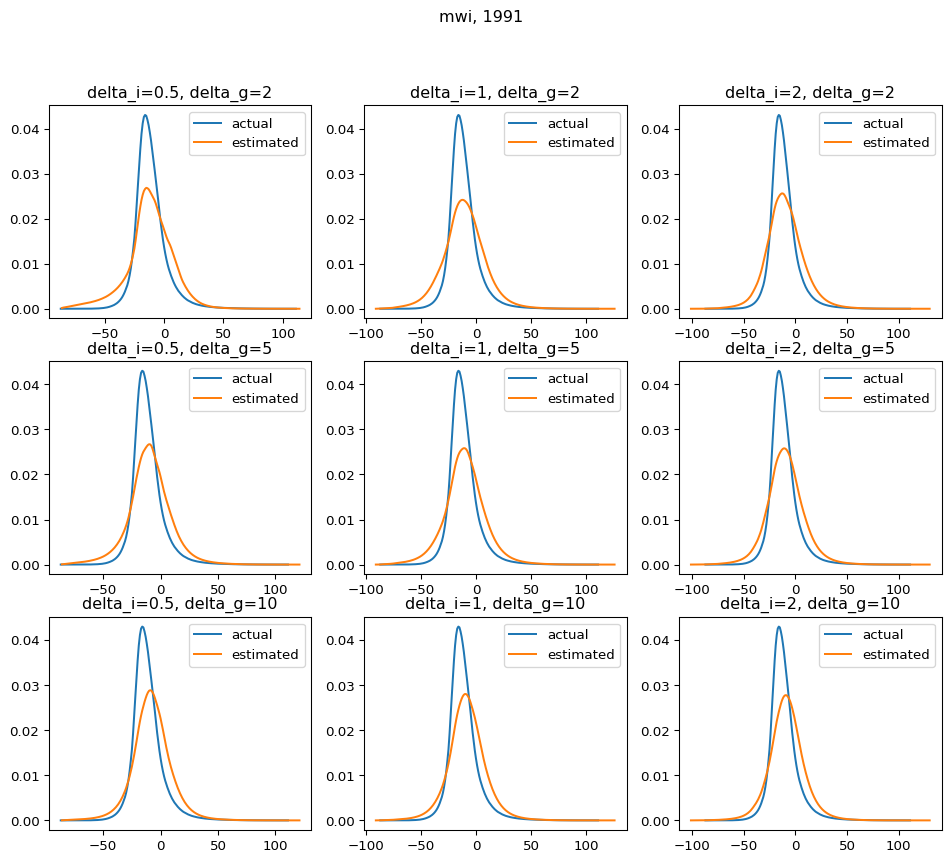

In [104]:
ns = [
    (0.5, 2),
    (1, 2),
    (2, 2),
    (0.5, 5),
    (1, 5),
    (2, 5),
    (0.5, 10),
    (1, 10),
    (2, 10)
]
x = ('mwi', 1991)


do_plot3(x, ns, get_neighbors_rectangle2)

('bra', 1990)
i = 9.4026, g = 59.0
delta_i = 0.5, delta_g = 2
using 43 shapes
delta_i = 1, delta_g = 2
using 112 shapes
delta_i = 2, delta_g = 2
using 180 shapes
delta_i = 0.5, delta_g = 5
using 104 shapes
delta_i = 1, delta_g = 5
using 275 shapes
delta_i = 2, delta_g = 5
using 484 shapes
delta_i = 0.5, delta_g = 10
using 211 shapes
delta_i = 1, delta_g = 10
using 567 shapes
delta_i = 2, delta_g = 10
using 950 shapes


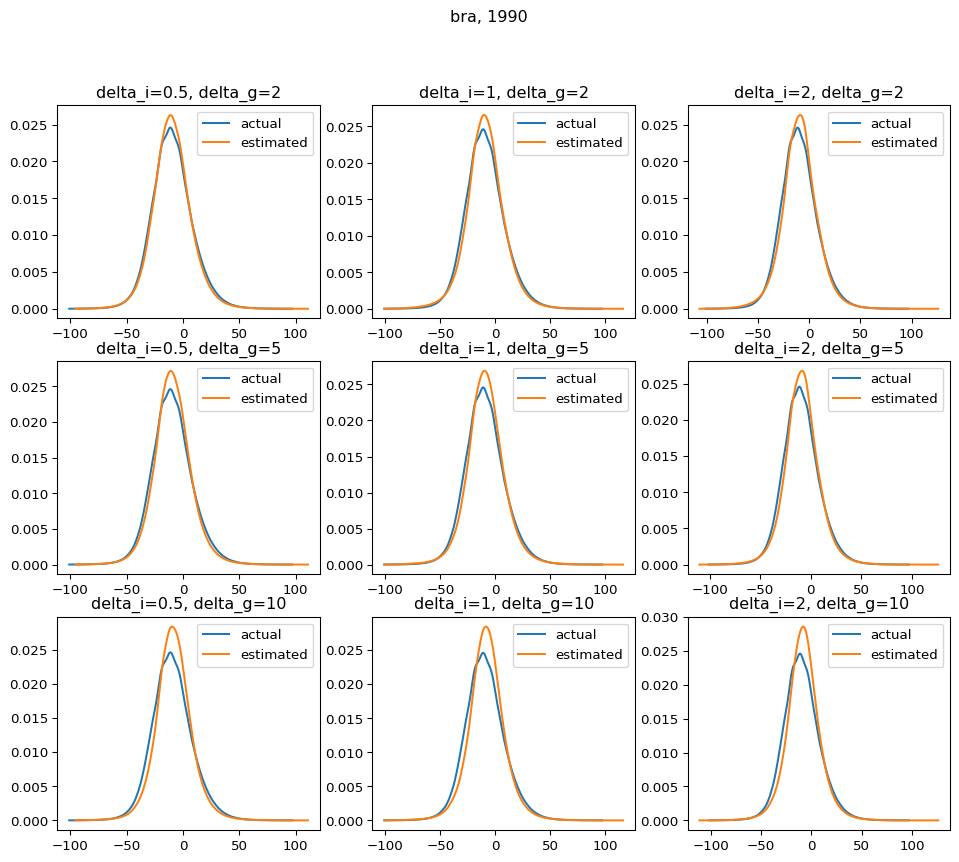

In [105]:
ns = [
    (0.5, 2),
    (1, 2),
    (2, 2),
    (0.5, 5),
    (1, 5),
    (2, 5),
    (0.5, 10),
    (1, 10),
    (2, 10)
]
x = ('bra', 1990)


do_plot3(x, ns, get_neighbors_rectangle2)

('swe', 2015)
i = 55.2617, g = 28.8
delta_i = 0.5, delta_g = 2
using 135 shapes
delta_i = 1, delta_g = 2
using 255 shapes
delta_i = 2, delta_g = 2
using 637 shapes
delta_i = 0.5, delta_g = 5
using 316 shapes
delta_i = 1, delta_g = 5
using 597 shapes
delta_i = 2, delta_g = 5
using 1510 shapes
delta_i = 0.5, delta_g = 10
using 564 shapes
delta_i = 1, delta_g = 10
using 1150 shapes
delta_i = 2, delta_g = 10
using 2559 shapes


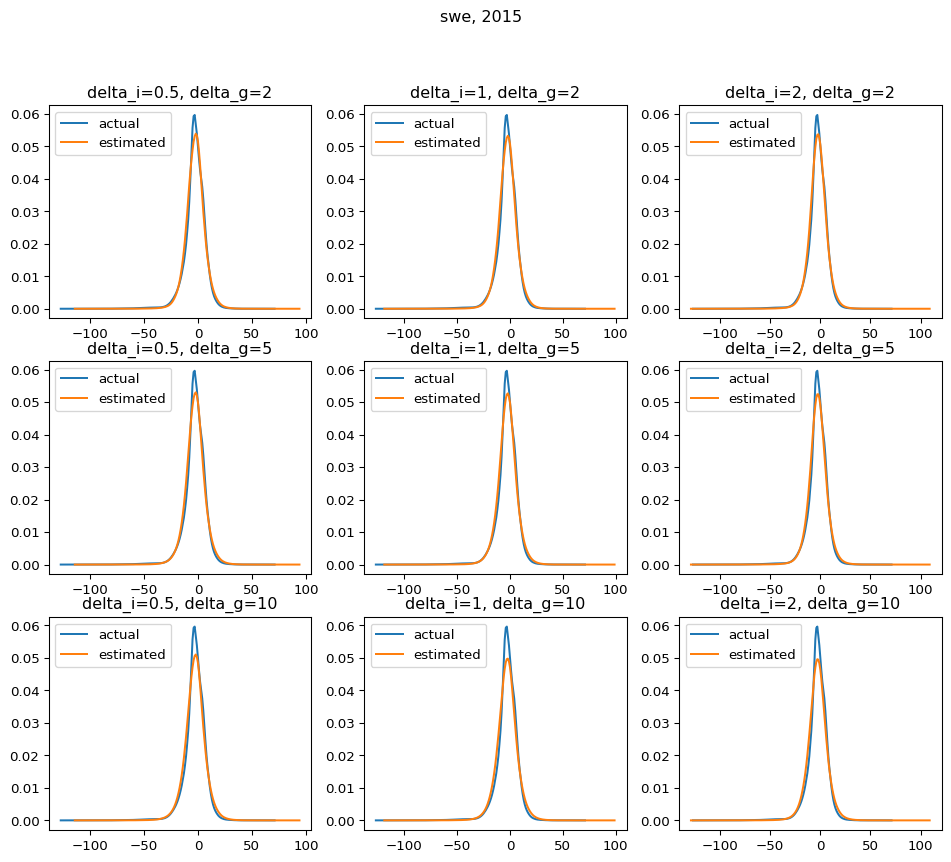

In [106]:
ns = [
    (0.5, 2),
    (1, 2),
    (2, 2),
    (0.5, 5),
    (1, 5),
    (2, 5),
    (0.5, 10),
    (1, 10),
    (2, 10)
]
x = ('swe', 2015)


do_plot3(x, ns, get_neighbors_rectangle2)

('tjk', 2000)
i = 2.7311, g = 30.9
delta_i = 0.5, delta_g = 2
using 89 shapes
delta_i = 1, delta_g = 2
using 174 shapes
delta_i = 2, delta_g = 2
using 399 shapes
delta_i = 0.5, delta_g = 5
using 248 shapes
delta_i = 1, delta_g = 5
using 464 shapes
delta_i = 2, delta_g = 5
using 910 shapes
delta_i = 0.5, delta_g = 10
using 449 shapes
delta_i = 1, delta_g = 10
using 796 shapes
delta_i = 2, delta_g = 10
using 1665 shapes


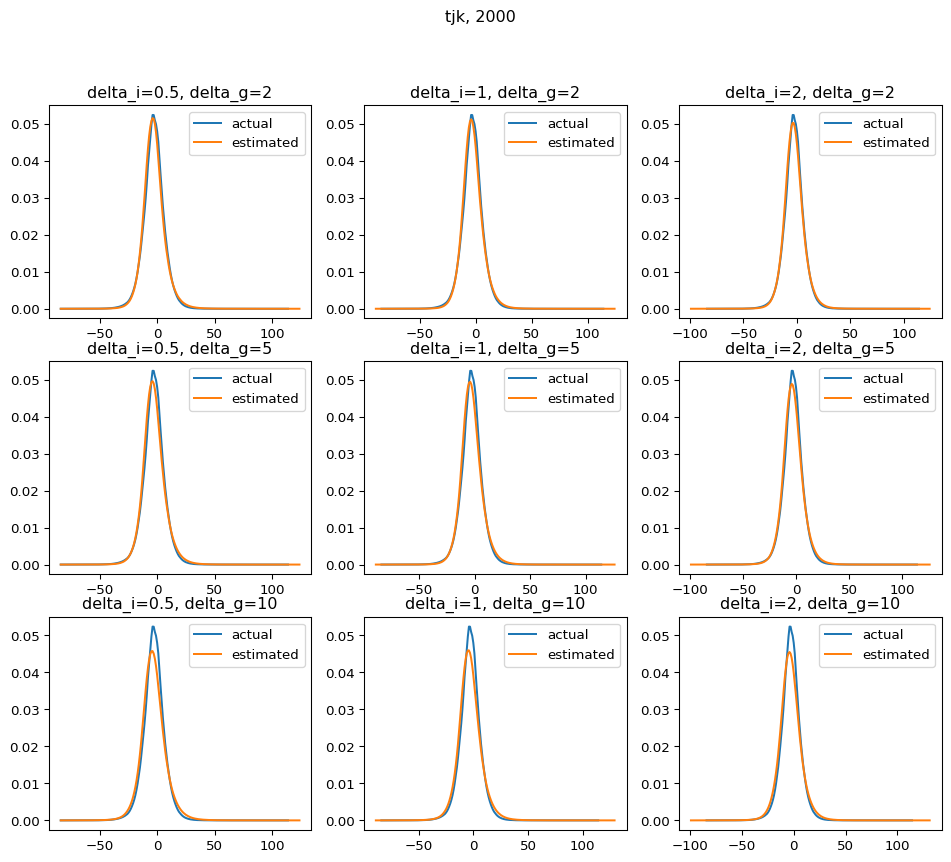

In [107]:
ns = [
    (0.5, 2),
    (1, 2),
    (2, 2),
    (0.5, 5),
    (1, 5),
    (2, 5),
    (0.5, 10),
    (1, 10),
    (2, 10)
]
x = ('tjk', 2000)


do_plot3(x, ns, get_neighbors_rectangle2)

('caf', 1993)
i = 1.2222, g = 60.2
delta_i = 0.5, delta_g = 2
using 20 shapes
delta_i = 1, delta_g = 2
using 23 shapes
delta_i = 2, delta_g = 2
using 50 shapes
delta_i = 0.5, delta_g = 5
using 28 shapes
delta_i = 1, delta_g = 5
using 48 shapes
delta_i = 2, delta_g = 5
using 137 shapes
delta_i = 0.5, delta_g = 10
using 63 shapes
delta_i = 1, delta_g = 10
using 116 shapes
delta_i = 2, delta_g = 10
using 337 shapes


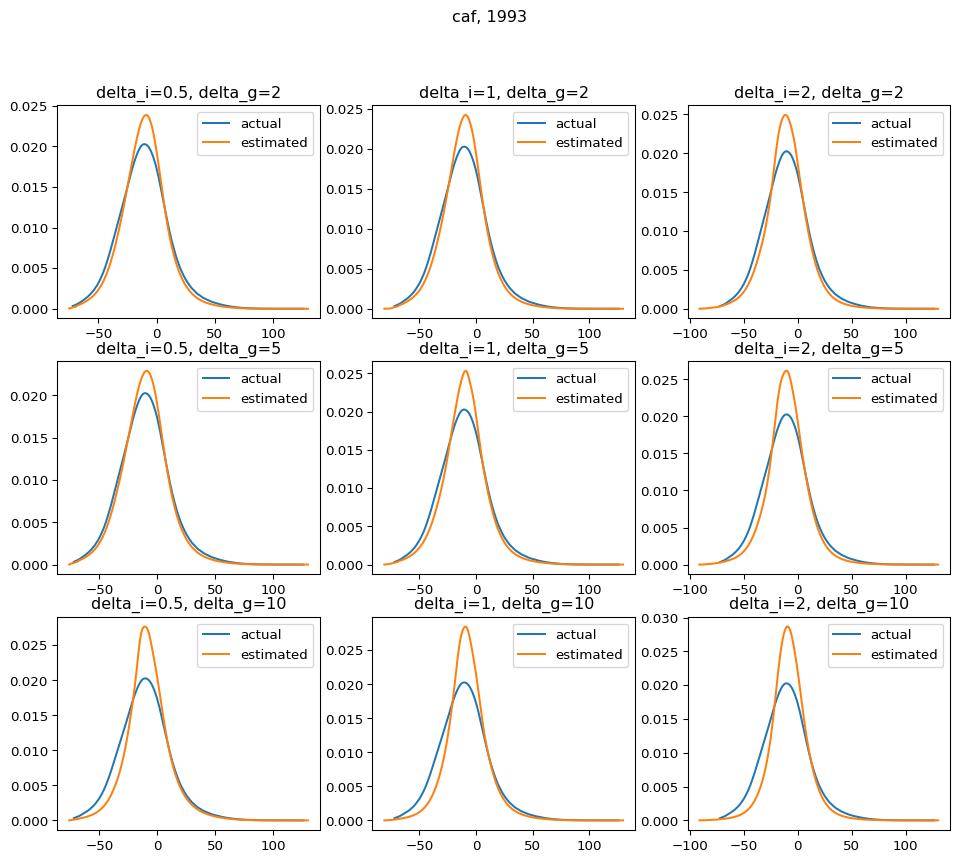

In [108]:
ns = [
    (0.5, 2),
    (1, 2),
    (2, 2),
    (0.5, 5),
    (1, 5),
    (2, 5),
    (0.5, 10),
    (1, 10),
    (2, 10)
]
x = ('caf', 1993)


do_plot3(x, ns, get_neighbors_rectangle2)

('tha', 1981)
i = 5.5729, g = 44.9
delta_i = 0.5, delta_g = 2
using 235 shapes
delta_i = 1, delta_g = 2
using 388 shapes
delta_i = 2, delta_g = 2
using 563 shapes
delta_i = 0.5, delta_g = 5
using 492 shapes
delta_i = 1, delta_g = 5
using 883 shapes
delta_i = 2, delta_g = 5
using 1470 shapes
delta_i = 0.5, delta_g = 10
using 876 shapes
delta_i = 1, delta_g = 10
using 1659 shapes
delta_i = 2, delta_g = 10
using 2881 shapes


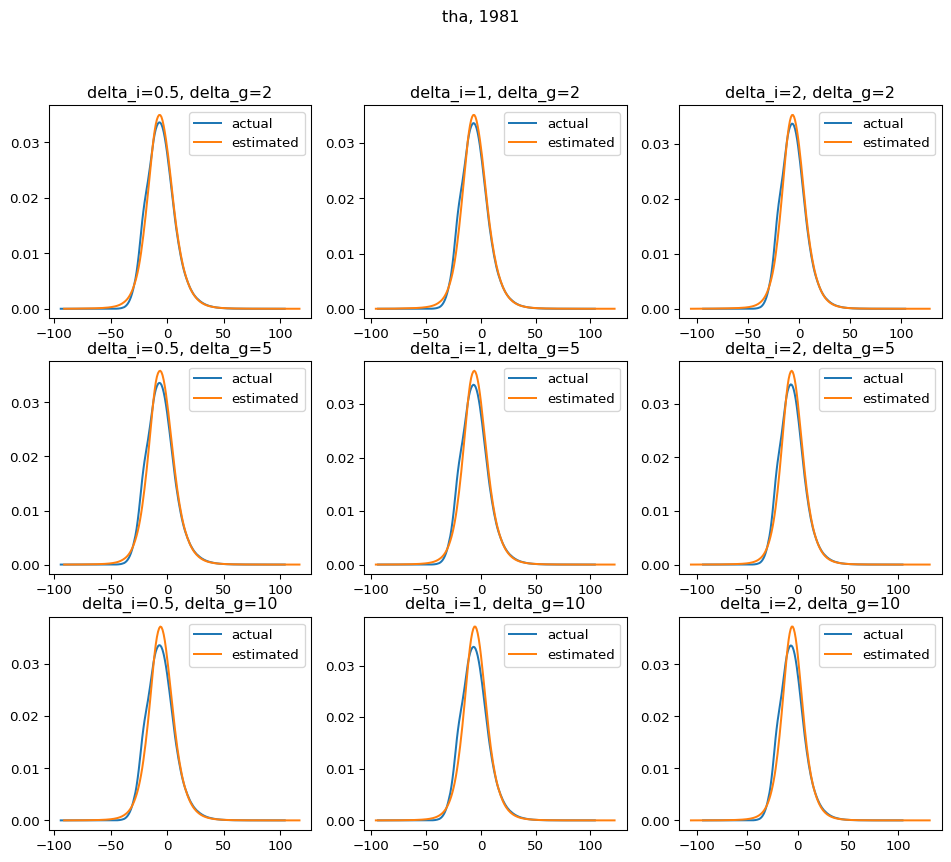

In [109]:
ns = [
    (0.5, 2),
    (1, 2),
    (2, 2),
    (0.5, 5),
    (1, 5),
    (2, 5),
    (0.5, 10),
    (1, 10),
    (2, 10)
]
x = ('tha', 1981)


do_plot3(x, ns, get_neighbors_rectangle2)